## Imports

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
projectdir = "/home/jovyan/work/MED_Fall"
workdir = "/home/jovyan/work"

In [4]:
import os

os.environ["PYTHONPATH"]

'/home/jovyan/work/MED_Fall/'

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from vision.pre_processing.extract_frames import FramesExtractor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.utility_functions import listdir_nohidden_sorted as lsdir
from utils.utility_functions import load_images, show_images

In [6]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup the dataframe for keras flow_from_dataframe pipeline

In [7]:
extracted_frames_path = (
    "/home/jovyan/work/MED_Fall/vision/vision_dataset/extracted_frames"
)

In [8]:
start = len(extracted_frames_path) + 1
frames_names = lsdir(extracted_frames_path)
frames_names = list(map(lambda x: x[start:], frames_names))
pd.Series(frames_names[:5])

0    actor_1_bed_cam_1_0000.jpg
1    actor_1_bed_cam_1_0001.jpg
2    actor_1_bed_cam_1_0002.jpg
3    actor_1_bed_cam_1_0003.jpg
4    actor_1_bed_cam_1_0004.jpg
dtype: object

In [9]:
print(len(frames_names))

1182300


In [10]:
ground_truth_path = "/home/jovyan/work/MED_Fall/vision/vision_dataset/ground_truth"
len(lsdir(ground_truth_path))

50

In [11]:
dfs = []
for file in lsdir(ground_truth_path):
    df = pd.read_csv(file)
    dfs.append(df)
dataset = pd.concat(dfs, ignore_index=True)

dataset = dataset.iloc[:, 1:]
dataset

micro_labels macro_labels            ar_labels  \
0                  lie_still   lying_down  actor_repositioning   
1                  lie_still   lying_down  actor_repositioning   
2                  lie_still   lying_down  actor_repositioning   
3                  lie_still   lying_down  actor_repositioning   
4                  lie_still   lying_down  actor_repositioning   
...                      ...          ...                  ...   
1182295  stand_up_from_floor          adl  actor_repositioning   
1182296  stand_up_from_floor          adl  actor_repositioning   
1182297  stand_up_from_floor          adl  actor_repositioning   
1182298  stand_up_from_floor          adl  actor_repositioning   
1182299  stand_up_from_floor          adl  actor_repositioning   

                               frame_name  
0                  actor_1_bed_cam_1_0000  
1                  actor_1_bed_cam_1_0001  
2                  actor_1_bed_cam_1_0002  
3                  actor_1_bed_cam_1_0003  
4                  actor_1_bed_cam_1_0004  
...                                   ...  
1182295  actor_4_chair_full_ph_cam_7_4615  
1182296  actor_4_chair_full_ph_cam_7_4616  
1182297  actor_4_chair_full_ph_cam_7_4617  
1182298  actor_4_chair_full_ph_cam_7_4618  
1182299  actor_4_chair_full_ph_cam_7_4619  

[1182300 rows x 4 columns]

In [12]:
dataset["frame_name"] = pd.Series(frames_names)
dataset

micro_labels macro_labels            ar_labels  \
0                  lie_still   lying_down  actor_repositioning   
1                  lie_still   lying_down  actor_repositioning   
2                  lie_still   lying_down  actor_repositioning   
3                  lie_still   lying_down  actor_repositioning   
4                  lie_still   lying_down  actor_repositioning   
...                      ...          ...                  ...   
1182295  stand_up_from_floor          adl  actor_repositioning   
1182296  stand_up_from_floor          adl  actor_repositioning   
1182297  stand_up_from_floor          adl  actor_repositioning   
1182298  stand_up_from_floor          adl  actor_repositioning   
1182299  stand_up_from_floor          adl  actor_repositioning   

                                   frame_name  
0                  actor_1_bed_cam_1_0000.jpg  
1                  actor_1_bed_cam_1_0001.jpg  
2                  actor_1_bed_cam_1_0002.jpg  
3                  actor_1_bed_cam_1_0003.jpg  
4                  actor_1_bed_cam_1_0004.jpg  
...                                       ...  
1182295  actor_4_chair_full_ph_cam_7_4615.jpg  
1182296  actor_4_chair_full_ph_cam_7_4616.jpg  
1182297  actor_4_chair_full_ph_cam_7_4617.jpg  
1182298  actor_4_chair_full_ph_cam_7_4618.jpg  
1182299  actor_4_chair_full_ph_cam_7_4619.jpg  

[1182300 rows x 4 columns]

### Visualize some frames from the dataset

In [13]:
##removector repositioning

on_air_ds = dataset.loc[dataset["ar_labels"] == "on_air"]
on_air_ds

micro_labels macro_labels ar_labels  \
206      sit_up_from_lying          adl    on_air   
207      sit_up_from_lying          adl    on_air   
208      sit_up_from_lying          adl    on_air   
209      sit_up_from_lying          adl    on_air   
210      sit_up_from_lying          adl    on_air   
...                    ...          ...       ...   
1182213     crouched_still   lying_down    on_air   
1182214     crouched_still   lying_down    on_air   
1182215     crouched_still   lying_down    on_air   
1182216     crouched_still   lying_down    on_air   
1182217     crouched_still   lying_down    on_air   

                                   frame_name  
206                actor_1_bed_cam_1_0206.jpg  
207                actor_1_bed_cam_1_0207.jpg  
208                actor_1_bed_cam_1_0208.jpg  
209                actor_1_bed_cam_1_0209.jpg  
210                actor_1_bed_cam_1_0210.jpg  
...                                       ...  
1182213  actor_4_chair_full_ph_cam_7_4533.jpg  
1182214  actor_4_chair_full_ph_cam_7_4534.jpg  
1182215  actor_4_chair_full_ph_cam_7_4535.jpg  
1182216  actor_4_chair_full_ph_cam_7_4536.jpg  
1182217  actor_4_chair_full_ph_cam_7_4537.jpg  

[386106 rows x 4 columns]

In [14]:
dataset.loc[dataset["frame_name"] == "actor_2_chair_cam_1_0528.jpg"]

micro_labels macro_labels            ar_labels  \
592728    sit_still          adl  actor_repositioning   

                          frame_name  
592728  actor_2_chair_cam_1_0528.jpg

In [15]:
rand_samples = on_air_ds.groupby("macro_labels").sample(n=10)
rand_samples

micro_labels macro_labels ar_labels  \
957548       sit_up_from_lying          adl    on_air   
839667       sit_up_from_lying          adl    on_air   
503720       sit_up_from_lying          adl    on_air   
756624       sit_up_from_lying          adl    on_air   
1002923      stand_up_from_sit          adl    on_air   
770536       stand_up_from_sit          adl    on_air   
1156073      stand_up_from_sit          adl    on_air   
491496       sit_up_from_lying          adl    on_air   
297881       sit_up_from_lying          adl    on_air   
536610       sit_up_from_lying          adl    on_air   
712095            fall_lateral      falling    on_air   
202447             fall_crouch      falling    on_air   
898012            fall_rolling      falling    on_air   
280752            fall_lateral      falling    on_air   
967354             fall_crouch      falling    on_air   
488895             fall_crouch      falling    on_air   
1149406            fall_crouch      falling    on_air   
921467            fall_frontal      falling    on_air   
754562             fall_crouch      falling    on_air   
372842            fall_lateral      falling    on_air   
291577   lie_down_on_the_floor   lying_down    on_air   
313590   lie_down_on_the_floor   lying_down    on_air   
12728    lie_down_on_the_floor   lying_down    on_air   
145709          crouched_still   lying_down    on_air   
392631   lie_down_on_the_floor   lying_down    on_air   
330269   lie_down_on_the_floor   lying_down    on_air   
199540          crouched_still   lying_down    on_air   
318384   lie_down_on_the_floor   lying_down    on_air   
872532   lie_down_on_the_floor   lying_down    on_air   
89351    lie_down_on_the_floor   lying_down    on_air   

                                        frame_name  
957548         actor_3_walk_full_ph_cam_4_2588.jpg  
839667                  actor_3_bed_cam_7_0627.jpg  
503720          actor_2_bed_full_ph_cam_2_3380.jpg  
756624         actor_2_walk_full_ph_cam_2_1824.jpg  
1002923  actor_3_walk_stick_full_ph_cam_6_0803.jpg  
770536         actor_2_walk_full_ph_cam_6_3676.jpg  
1156073       actor_4_chair_full_ph_cam_2_1493.jpg  
491496                  actor_2_bed_cam_7_5196.jpg  
297881                 actor_1_walk_cam_6_2381.jpg  
536610               actor_2_bed_ph_cam_6_0270.jpg  
712095                 actor_2_walk_cam_3_0135.jpg  
202447             actor_1_chair_ph_cam_5_2767.jpg  
898012              actor_3_rolling_cam_1_0892.jpg  
280752                 actor_1_walk_cam_3_2532.jpg  
967354         actor_3_walk_full_ph_cam_6_3514.jpg  
488895                  actor_2_bed_cam_7_2595.jpg  
1149406               actor_4_chair_cam_7_1786.jpg  
921467                 actor_3_walk_cam_3_0827.jpg  
754562       actor_2_walk_full_ph_cam_2_2_3779.jpg  
372842    actor_1_walk_shoe_full_ph_cam_1_1142.jpg  
291577                 actor_1_walk_cam_5_1837.jpg  
313590         actor_1_walk_full_ph_cam_3_1050.jpg  
12728                   actor_1_bed_cam_3_4088.jpg  
145709                actor_1_chair_cam_5_3989.jpg  
392631    actor_1_walk_shoe_full_ph_cam_4_3471.jpg  
330269              actor_1_walk_ph_cam_1_3929.jpg  
199540             actor_1_chair_ph_cam_4_4000.jpg  
318384         actor_1_walk_full_ph_cam_5_0324.jpg  
872532                actor_3_chair_cam_4_1092.jpg  
89351                actor_1_bed_ph_cam_7_0911.jpg

In [150]:
##concatenare alla macro label il nome del fotogramma

titles = rand_samples["frame_name"] + rand_samples["macro_labels"]
titles

129476                       actor_1_chair_cam_2_0176.jpgadl
945029                actor_3_walk_full_ph_cam_1_3389.jpgadl
131414                       actor_1_chair_cam_2_2114.jpgadl
396787           actor_1_walk_shoe_full_ph_cam_5_1807.jpgadl
17640                          actor_1_bed_cam_5_0360.jpgadl
800907                     actor_2_walk_ph_cam_5_2067.jpgadl
903352                     actor_3_rolling_cam_6_0832.jpgadl
709153                        actor_2_walk_cam_2_4153.jpgadl
255043               actor_1_walk2_full_ph_cam_6_3943.jpgadl
1174630              actor_4_chair_full_ph_cam_6_1570.jpgadl
1015691                    actor_4_bed_cam_1_1811.jpgfalling
945159            actor_3_walk_full_ph_cam_1_3519.jpgfalling
329227                 actor_1_walk_ph_cam_1_2887.jpgfalling
1174170          actor_4_chair_full_ph_cam_6_1110.jpgfalling
626876                actor_2_chair_ph_cam_1_0656.jpgfalling
961394            actor_3_walk_full_ph_cam_5_1994.jpgfalling
447241              acto

(30, 224, 224, 3)


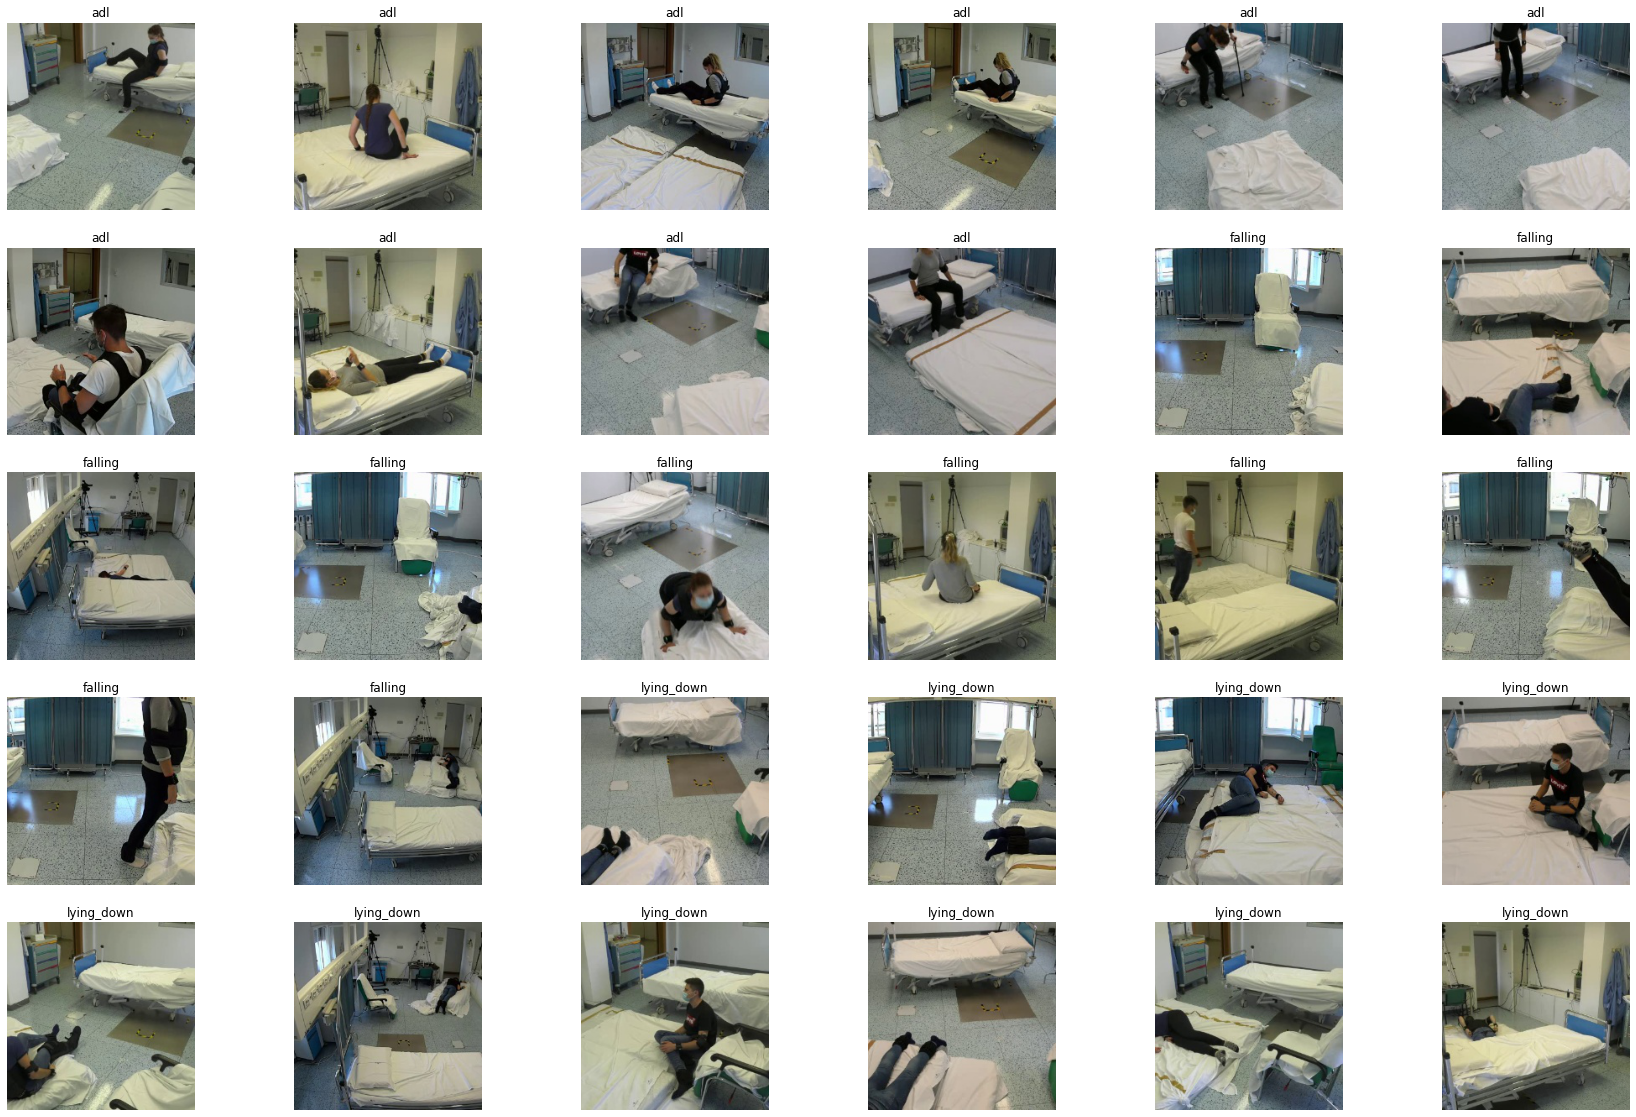

In [17]:
images = load_images(extracted_frames_path, rand_samples["frame_name"])

show_images(images, rows=5, figsize=(30, 20), titles=rand_samples["macro_labels"])

## Subsample dataset choosing Actor 4 as fine tuning data

In [13]:
# select only actor 4
actor_4_dataset = dataset[dataset["frame_name"].str.contains("actor_4")]

In [14]:
actor_4_dataset.reset_index(drop=True, inplace=True)
actor_4_dataset

micro_labels macro_labels            ar_labels  \
0                 lie_still   lying_down  actor_repositioning   
1                 lie_still   lying_down  actor_repositioning   
2                 lie_still   lying_down  actor_repositioning   
3                 lie_still   lying_down  actor_repositioning   
4                 lie_still   lying_down  actor_repositioning   
...                     ...          ...                  ...   
168415  stand_up_from_floor          adl  actor_repositioning   
168416  stand_up_from_floor          adl  actor_repositioning   
168417  stand_up_from_floor          adl  actor_repositioning   
168418  stand_up_from_floor          adl  actor_repositioning   
168419  stand_up_from_floor          adl  actor_repositioning   

                                  frame_name  
0                 actor_4_bed_cam_1_0000.jpg  
1                 actor_4_bed_cam_1_0001.jpg  
2                 actor_4_bed_cam_1_0002.jpg  
3                 actor_4_bed_cam_1_0003.jpg  
4                 actor_4_bed_cam_1_0004.jpg  
...                                      ...  
168415  actor_4_chair_full_ph_cam_7_4615.jpg  
168416  actor_4_chair_full_ph_cam_7_4616.jpg  
168417  actor_4_chair_full_ph_cam_7_4617.jpg  
168418  actor_4_chair_full_ph_cam_7_4618.jpg  
168419  actor_4_chair_full_ph_cam_7_4619.jpg  

[168420 rows x 4 columns]

In [15]:
train_set = actor_4_dataset.sample(
    frac=0.9, random_state=2
)  # random state is a seed value
val_set = actor_4_dataset.drop(train_set.index)

print(train_set.shape, val_set.shape)

(151578, 4) (16842, 4)


In [16]:
train_set["macro_labels"].value_counts()

adl           122360
lying_down     20453
falling         8765
Name: macro_labels, dtype: int64

In [17]:
adl_train = train_set.loc[train_set["macro_labels"] == "adl"]
adl_train.reset_index(drop=True, inplace=True)
adl_train

micro_labels macro_labels            ar_labels  \
0       lie_down_from_sitting          adl  actor_repositioning   
1                 stand_still          adl  actor_repositioning   
2         stand_up_from_floor          adl  actor_repositioning   
3           sit_up_from_lying          adl               on_air   
4           sit_up_from_lying          adl               on_air   
...                       ...          ...                  ...   
122355    stand_up_from_floor          adl  actor_repositioning   
122356  lie_down_from_sitting          adl  actor_repositioning   
122357      stand_up_from_sit          adl               on_air   
122358      sit_up_from_lying          adl               on_air   
122359            stand_still          adl  actor_repositioning   

                                  frame_name  
0                 actor_4_bed_cam_3_0445.jpg  
1         actor_4_bed_full_ph_cam_4_7022.jpg  
2       actor_4_chair_full_ph_cam_4_2359.jpg  
3                 actor_4_bed_cam_3_1165.jpg  
4                 actor_4_bed_cam_1_0131.jpg  
...                                      ...  
122355  actor_4_chair_full_ph_cam_4_0746.jpg  
122356    actor_4_bed_full_ph_cam_2_5184.jpg  
122357    actor_4_bed_full_ph_cam_7_1844.jpg  
122358    actor_4_bed_full_ph_cam_4_0187.jpg  
122359    actor_4_bed_full_ph_cam_6_7403.jpg  

[122360 rows x 4 columns]

In [18]:
lying_down_n_samples = train_set["macro_labels"].value_counts()[1]
lying_down_n_samples

20453

In [19]:
adl_train_under = adl_train.sample(n=lying_down_n_samples, random_state=2)
adl_train_under

micro_labels macro_labels            ar_labels  \
6011               stand_still          adl  actor_repositioning   
103894  sit_down_from_standing          adl  actor_repositioning   
121657     stand_up_from_floor          adl  actor_repositioning   
92094              stand_still          adl  actor_repositioning   
75005      stand_up_from_floor          adl  actor_repositioning   
...                        ...          ...                  ...   
100976             stand_still          adl  actor_repositioning   
3589               rolling_bed          adl               on_air   
91959      stand_up_from_floor          adl  actor_repositioning   
35088      stand_up_from_floor          adl  actor_repositioning   
87558      stand_up_from_floor          adl  actor_repositioning   

                                  frame_name  
6011     actor_4_bed_full_ph_cam_6_10947.jpg  
103894            actor_4_bed_cam_7_2736.jpg  
121657    actor_4_bed_full_ph_cam_6_2001.jpg  
92094             actor_4_bed_cam_2_2620.jpg  
75005   actor_4_chair_full_ph_cam_7_2451.jpg  
...                                      ...  
100976   actor_4_bed_full_ph_cam_1_11451.jpg  
3589      actor_4_bed_rolling_cam_2_0177.jpg  
91959           actor_4_chair_cam_4_1063.jpg  
35088     actor_4_bed_full_ph_cam_5_3401.jpg  
87558           actor_4_chair_cam_3_1550.jpg  

[20453 rows x 4 columns]

In [20]:
train_set_copy = train_set.copy()
train_set_copy = train_set_copy[train_set_copy["macro_labels"] != "adl"]
train_set_copy

micro_labels macro_labels            ar_labels  \
59896               lie_still   lying_down  actor_repositioning   
115867           fall_rolling      falling               on_air   
20943               lie_still   lying_down  actor_repositioning   
90841            fall_lateral      falling               on_air   
128548         crouched_still   lying_down               on_air   
...                       ...          ...                  ...   
25898               lie_still   lying_down  actor_repositioning   
24940               lie_still   lying_down  actor_repositioning   
12103               lie_still   lying_down  actor_repositioning   
142975  lie_down_on_the_floor   lying_down               on_air   
144746         crouched_still   lying_down               on_air   

                                  frame_name  
59896     actor_4_bed_full_ph_cam_4_5296.jpg  
115867    actor_4_bed_rolling_cam_4_0967.jpg  
20943     actor_4_bed_full_ph_cam_1_1623.jpg  
90841     actor_4_bed_full_ph_cam_7_0961.jpg  
128548          actor_4_chair_cam_4_1828.jpg  
...                                      ...  
25898     actor_4_bed_full_ph_cam_1_6578.jpg  
24940     actor_4_bed_full_ph_cam_1_5620.jpg  
12103             actor_4_bed_cam_5_1063.jpg  
142975  actor_4_chair_full_ph_cam_2_2275.jpg  
144746  actor_4_chair_full_ph_cam_2_4046.jpg  

[29218 rows x 4 columns]

In [21]:
train_set_copy["macro_labels"].value_counts()

lying_down    20453
falling        8765
Name: macro_labels, dtype: int64

In [22]:
train_set_copy = pd.concat([train_set_copy, adl_train_under], axis=0)
train_set_copy

micro_labels macro_labels            ar_labels  \
59896             lie_still   lying_down  actor_repositioning   
115867         fall_rolling      falling               on_air   
20943             lie_still   lying_down  actor_repositioning   
90841          fall_lateral      falling               on_air   
128548       crouched_still   lying_down               on_air   
...                     ...          ...                  ...   
100976          stand_still          adl  actor_repositioning   
3589            rolling_bed          adl               on_air   
91959   stand_up_from_floor          adl  actor_repositioning   
35088   stand_up_from_floor          adl  actor_repositioning   
87558   stand_up_from_floor          adl  actor_repositioning   

                                 frame_name  
59896    actor_4_bed_full_ph_cam_4_5296.jpg  
115867   actor_4_bed_rolling_cam_4_0967.jpg  
20943    actor_4_bed_full_ph_cam_1_1623.jpg  
90841    actor_4_bed_full_ph_cam_7_0961.jpg  
128548         actor_4_chair_cam_4_1828.jpg  
...                                     ...  
100976  actor_4_bed_full_ph_cam_1_11451.jpg  
3589     actor_4_bed_rolling_cam_2_0177.jpg  
91959          actor_4_chair_cam_4_1063.jpg  
35088    actor_4_bed_full_ph_cam_5_3401.jpg  
87558          actor_4_chair_cam_3_1550.jpg  

[49671 rows x 4 columns]

## sample actor_1_bed_cam_1

In [121]:
actor_1_bed_cam_1 = dataset[dataset["frame_name"].str.contains("cam_1")]
actor_1_bed_cam_1 = actor_1_bed_cam_1[
    actor_1_bed_cam_1["ar_labels"].str.contains("on_air")
]

In [158]:
rand_samples = actor_1_bed_cam_1.groupby("macro_labels").sample(n=5)
rand_samples

micro_labels macro_labels ar_labels  \
426432       sit_up_from_lying          adl    on_air   
904899             rolling_bed          adl    on_air   
413646                 walking          adl    on_air   
520973       sit_up_from_lying          adl    on_air   
915437       sit_up_from_lying          adl    on_air   
782448             fall_crouch      falling    on_air   
450597            fall_frontal      falling    on_air   
127331            fall_lateral      falling    on_air   
814899            fall_lateral      falling    on_air   
1039953           fall_rolling      falling    on_air   
218734   lie_down_on_the_floor   lying_down    on_air   
843985   lie_down_on_the_floor   lying_down    on_air   
377404   lie_down_on_the_floor   lying_down    on_air   
67426    lie_down_on_the_floor   lying_down    on_air   
219652   lie_down_on_the_floor   lying_down    on_air   

                                        frame_name  
426432           actor_2_bed_armour_cam_1_3072.jpg  
904899      actor_3_rolling_full_ph_cam_1_0219.jpg  
413646   actor_1_walk_stick_full_ph_cam_1_1206.jpg  
520973               actor_2_bed_ph_cam_1_1433.jpg  
915437                 actor_3_walk_cam_1_3197.jpg  
782448              actor_2_walk_ph_cam_1_3768.jpg  
450597                  actor_2_bed_cam_1_2457.jpg  
127331                actor_1_chair_cam_1_2171.jpg  
814899   actor_2_walk_stick_full_ph_cam_1_0939.jpg  
1039953         actor_4_bed_full_ph_cam_1_6753.jpg  
218734        actor_1_walk2_full_ph_cam_1_6634.jpg  
843985          actor_3_bed_full_ph_cam_1_2305.jpg  
377404    actor_1_walk_shoe_full_ph_cam_1_5704.jpg  
67426                actor_1_bed_ph_cam_1_2746.jpg  
219652        actor_1_walk2_full_ph_cam_1_7552.jpg

(15, 224, 224, 3)


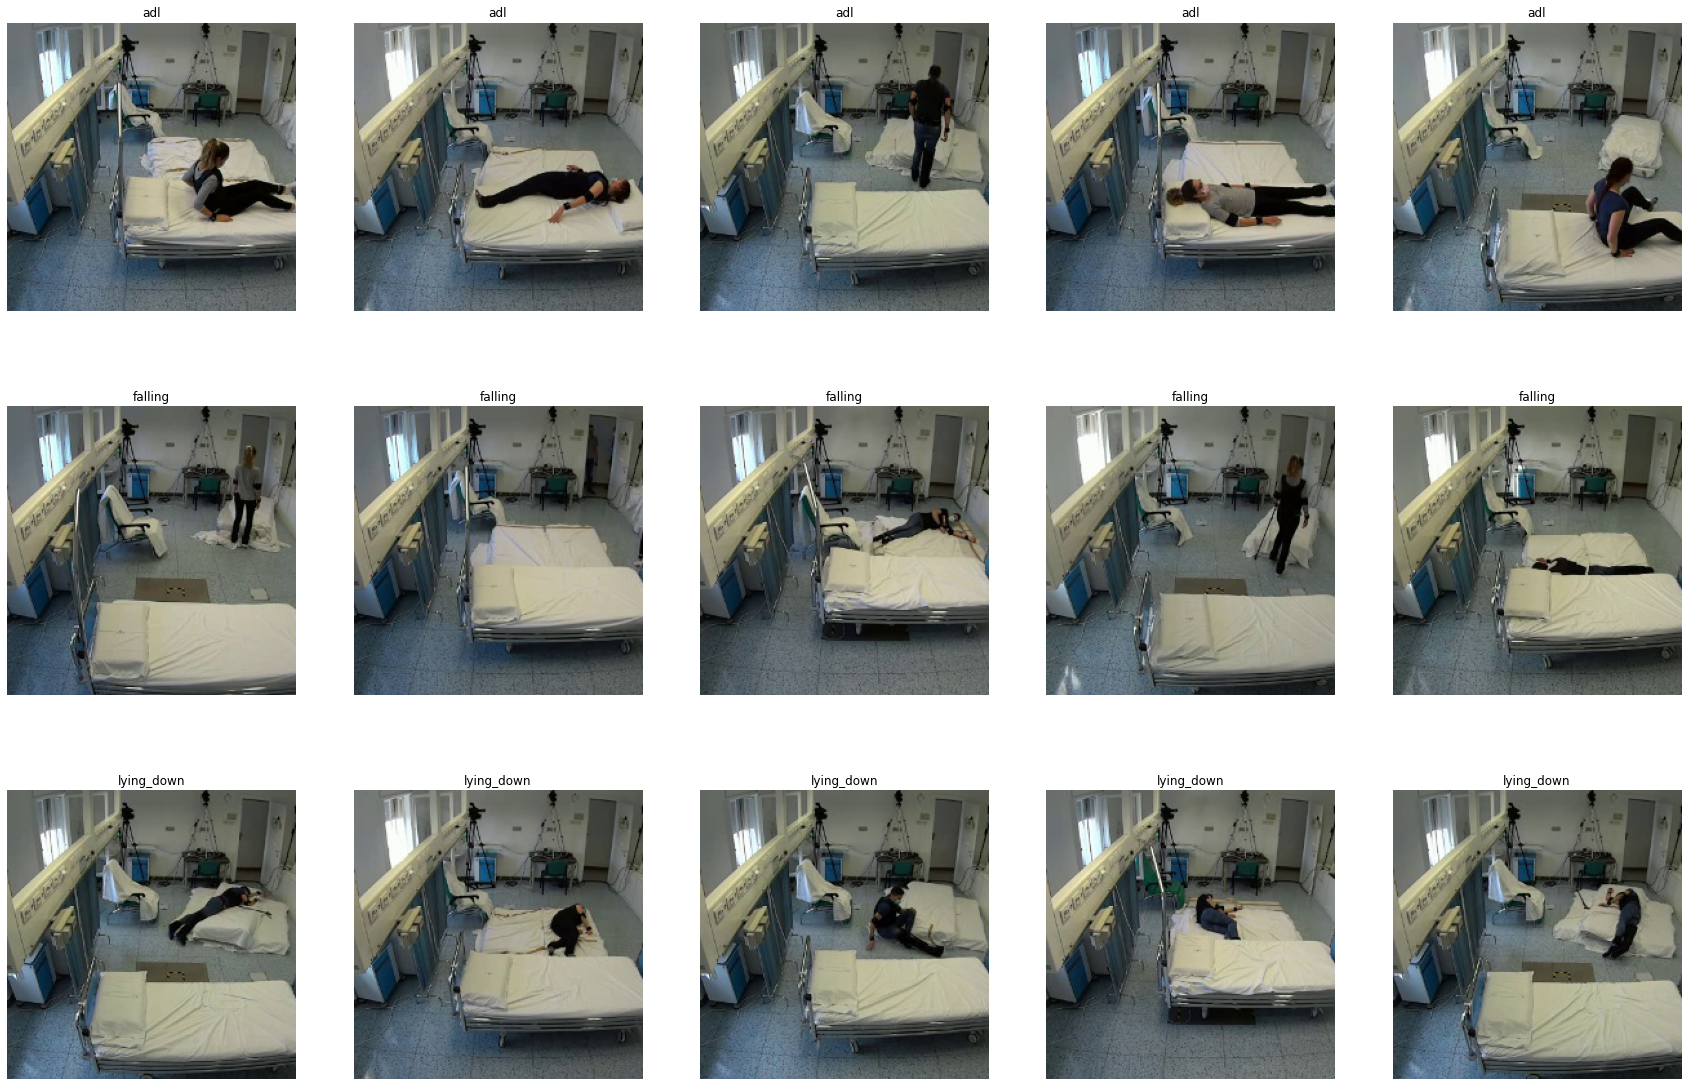

In [160]:
images = load_images(extracted_frames_path, rand_samples["frame_name"])
titles = rand_samples["macro_labels"]
show_images(images, titles=titles, figsize=(30, 20))

In [122]:
train_set = actor_1_bed_cam_1.sample(frac=0.8, random_state=2)
val_set = actor_1_bed_cam_1.drop(train_set.index)

train_set.shape, val_set.shape

((43228, 4), (10807, 4))

In [123]:
train_set_copy = train_set.copy()

## Fine tune VGG16 on Actor 4

### Creating Training and Validation Generators

In [124]:
train_set_copy["macro_labels"].value_counts()

adl           30266
falling        8888
lying_down     4074
Name: macro_labels, dtype: int64

In [125]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


train_datagen = train_generator.flow_from_dataframe(
    train_set_copy,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=2,
)

Found 43228 validated image filenames belonging to 3 classes.


In [126]:
val_generator = ImageDataGenerator(rescale=1.0 / 255)

val_datagen = val_generator.flow_from_dataframe(
    val_set,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    seed=2,
)

Found 10807 validated image filenames belonging to 3 classes.


In [153]:
print(pd.Series(train_datagen.classes).value_counts())
print(train_datagen.class_indices)

0    30266
1     8888
2     4074
dtype: int64
{'adl': 0, 'falling': 1, 'lying_down': 2}


In [156]:
print(pd.Series(val_datagen.classes).value_counts())
print(val_datagen.class_indices)

0    7531
1    2200
2    1076
dtype: int64
{'adl': 0, 'falling': 1, 'lying_down': 2}


### Download pre-trained VGG16

In [129]:
IMG_SIZE = (224, 224, 3)

In [130]:
feature_extractor = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SIZE,
    pooling="avg",
)

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Freeze all layers except last convolutional block

In [131]:
# freeze all layers except last five
for layer in feature_extractor.layers[:-9]:
    layer.trainable = False

for i, layer in enumerate(feature_extractor.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_3 True


### Add top layer to fine tune

In [132]:
x = feature_extractor.output
x = Flatten()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=3, activation="softmax")(x)

transfer_model = Model(inputs=feature_extractor.input, outputs=x)

transfer_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Compile the model and define callbacks

In [133]:
transfer_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(class_id=0),
        tf.keras.metrics.Recall(class_id=1),
        tf.keras.metrics.Recall(class_id=2),
    ],
)

In [134]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{projectdir}/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

In [135]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(patience=20),
]

### Train the model

In [ ]:
history = transfer_model.fit(
    train_datagen, validation_data=val_datagen, epochs=100, callbacks=callbacks
)

Epoch 1/100
676/676 [==============================] - 364s 538ms/step - loss: 0.7420 - accuracy: 0.6978 - recall_7: 0.8932 - recall_8: 0.0030 - recall_9: 9.8184e-04 - val_loss: 0.5694 - val_accuracy: 0.7552 - val_recall_7: 0.9134 - val_recall_8: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/100
676/676 [==============================] - 361s 534ms/step - loss: 0.4930 - accuracy: 0.7877 - recall_7: 0.9334 - recall_8: 0.3388 - recall_9: 0.0341 - val_loss: 0.4279 - val_accuracy: 0.8059 - val_recall_7: 0.9835 - val_recall_8: 0.5432 - val_recall_9: 0.0000e+00
Epoch 3/100
676/676 [==============================] - 357s 527ms/step - loss: 0.4027 - accuracy: 0.8226 - recall_7: 0.9567 - recall_8: 0.6040 - recall_9: 0.1298 - val_loss: 0.3734 - val_accuracy: 0.8346 - val_recall_7: 0.9703 - val_recall_8: 0.5982 - val_recall_9: 0.1552
Epoch 4/100
676/676 [==============================] - 360s 532ms/step - loss: 0.3531 - accuracy: 0.8423 - recall_7: 0.9649 - recall_8: 0.6401 - recall_9: 0.2730 - v

In [ ]:
#%cp /home/jovyan/work/MED_Fall/vision/model_checkpoints/vgg_top_fine_tuned_best_epoch.h5 /home/jovyan/work/persistent/

### Evaluate the model

In [145]:
transfer_model.evaluate(val_datagen)

169/169 [==============================] - 20s 118ms/step - loss: 0.0764 - accuracy: 0.9687 - recall_7: 0.9920 - recall_8: 0.8968 - recall_9: 0.9517


[0.07641121745109558,
 0.9687239527702332,
 0.9920329451560974,
 0.8968181610107422,
 0.9516728520393372]

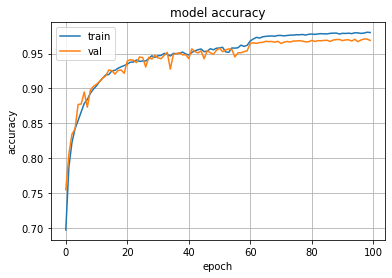

In [146]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

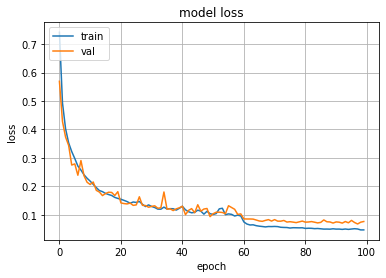

In [147]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [148]:
y_preds_logits = transfer_model.predict(val_datagen)

In [149]:
y_preds = np.argmax(y_preds_logits, axis=1)

In [157]:
print(
    classification_report(
        y_true=val_datagen.classes,
        y_pred=y_preds,
        target_names=list(val_datagen.class_indices.keys()),
    )
)

              precision    recall  f1-score   support

         adl       0.99      0.99      0.99      7531
     falling       0.95      0.90      0.92      2200
  lying_down       0.84      0.95      0.89      1076

    accuracy                           0.97     10807
   macro avg       0.93      0.95      0.94     10807
weighted avg       0.97      0.97      0.97     10807



In [151]:
pd.Series(train_datagen.classes).value_counts()

0    30266
1     8888
2     4074
dtype: int64

In [ ]:
## now fix labels of other cams